In [2]:
import os
import math
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

/root/anaconda3/envs/DATN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, A = False, **kwargs):
        super(CausalConv1d, self).__init__()

        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A  = A
        self.padding = (kernel_size - 1) * dilation + A * 1

        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride = 1,
                                      padding = 0,
                                      dilation = dilation,
                                      **kwargs )
                                    
    def forward(self, x):
        x = torch.nn.functional.pad(x, (self.padding, 0))
        conv1d_out = self.conv1d(x)
        if self.A :
            return conv1d_out[:,:,: -1]
        else:
            return conv1d_out

class Quantizer(nn.Module):
    def __init__(self, input_dim, codebook_dim, temp = 1.e7):
        super(Quantizer, self).__init__()
        self.temp = temp
        self.input_dim = input_dim
        self.codebook_dim = codebook_dim
        self.codebook = nn.Parameter(torch.FloatTensor(1,self.codebook_dim, ).uniform_(-1/self.codebook_dim, 1/self.codebook_dim))

    def indices2codebook(self, indices_onehot):
        return torch.matmul(indices_onehot, self.codebook.t()).squeeze()

    def indices_to_onehot(self, inputs_shape, indices):
        indices_hard = torch.zeros(inputs_shape[0], inputs_shape[1], self.codebook_dim)
        return indices_hard.scatter_(2, indices, 1)

    def forward(self, inputs):
        inputs_shape = inputs.shape
        inputs_repeat = inputs.unsqueeze(2).repeat(1,1,self.codebook_dim)
        distances = torch.exp(-torch.sqrt(torch.pow(inputs_repeat - self.codebook.unsqueeze(1), 2)))

        indices = torch.argmax(distances, dim = 2).unsqueeze(2)
        indices_hard = self.indices_to_onehot(inputs_shape = inputs_shape, indices = indices)

        indices_soft = torch.softmax(self.temp * distances, -1)
        quantized = self.indices2codebook(indices_onehot = indices_soft)

        return(indices_soft, indices_hard, quantized)




In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(D, M * 2), nn.BatchNorm1d(M * 2), nn.ReLU(),
                                     nn.Linear(M * 2, M), nn.BatchNorm1d(M), nn.ReLU(),
                                     nn.Linear(M, M // 2), nn.BatchNorm1d(M // 2), nn.ReLU(),
                                     nn.Linear(M // 2, C))
        
    def encode(self, x):
        h_e = self.encoder(x)
        return h_e
    
    def forward(self, x):
        return self.encode(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(C, M//2), nn.BatchNorm1d(M//2), nn.ReLU(),
                                     nn.Linear(M //2 , M), nn.BatchNorm1d(M), nn.ReLU(),
                                     nn.Linear(M, M * 2), nn.BatchNorm1d(M * 2), nn.ReLU(),
                                     nn.Linear(M * 2, D))
    
    def decode(self, z):
        h_d = self.decoder(z)
        return h_d

    def forward(self, z, x = None):
        x_rec = self.decode(z)
        return x_rec

In [6]:
class ARMEntropyCoding(nn.Module):
    def __init__(self, code_dim, codebook_dim):
        super(ARMEntropyCoding, self).__init__()
        self.code_dim = code_dim
        self.codebook_dim = codebook_dim
        self.arm_net = nn.Sequential(
            CausalConv1d(in_channels=1, out_channels=M_kernels, dilation=1, kernel_size=kernel, A=True, bias = True),
            nn.LeakyReLU(),
            CausalConv1d(in_channels=M_kernels, out_channels=M_kernels, dilation=1, kernel_size=kernel, A=False, bias = True),
            nn.LeakyReLU(),
            CausalConv1d(in_channels=M_kernels, out_channels=E, dilation=1, kernel_size=kernel, A=False, bias = True),
        )



    def f(self, x):
        h = self.arm_net(x.unsqueeze(1))
        h = h.permute(0, 2, 1)
        p = torch.softmax(h,2)

        return p
    
    def sample(self, quantizer = None, B =10):
        x_new = torch.zeros((B, self.code_dim))

        for d in range(self.code_dim):
            p = self.f(x_new)
            indx_d = torch.multinomial(p[:, d, :], num_samples = 1)
            codebook_value = quantizer.codebook[0, indx_d].squeeze()
            x_new[:, d] = codebook_value
        
        return x_new


    def forward(self, z, x):
        p = self.f(x)
        return -torch.sum(z * torch.log(p), 2)

In [7]:
class NeuralCompressor(nn.Module):
    def __init__(self, encoder, decoder, entropy_coding, quantizer, beta = 1., detaching = False):
        super(NeuralCompressor, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.entropy_coding = entropy_coding
        self.quantizer = quantizer

        self.beta = beta
        self.detaching = detaching

    def forward(self, x, reduction = 'avg'):
        z = self.encoder(x)
        quantizer_out = self.quantizer(z)
        x_rec = self.decoder(quantizer_out[2])
        Distortion = torch.mean(torch.pow(x - x_rec, 2), 1)
        Rate = torch.mean(self.entropy_coding(quantizer_out[0], quantizer_out[2]), 1)
        objective = Distortion + self.beta * Rate

        if reduction == 'sum':
            return objective.sum(), Distortion.sum(), Rate.sum()
        else:
            return objective.mean(), Distortion.mean(), Rate.mean()

In [8]:
D = 64
C = 16
E = 16
M = 256
M_kernels = 32
kernel = 4
entropy_coding_type = 'arm'
lr = 1e-3
num_epochs = 1000
max_patience = 50
beta = 1

In [9]:
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(input_dim=C, codebook_dim=E)
entropy_coding = ARMEntropyCoding(code_dim=C, codebook_dim=E)

model = NeuralCompressor(encoder=encoder, decoder=decoder, entropy_coding=entropy_coding, quantizer=quantizer, beta=beta )

In [10]:
#load model type .model by pytorch
model = torch.load('/workspace/nttrang2108/VHT/Neural_Compression/neural_compressor_arm_C_16_E_8.model')

In [11]:
model.eval()

NeuralCompressor(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=128, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, 

In [12]:
class Digits(Dataset):
    def __init__(self, mode ='train', transforms = None):
        digits = load_digits()
        if mode =='train':
            self.data =digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)
        
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [13]:
test_data = Digits(mode = 'test')

torch.Size([4, 64])


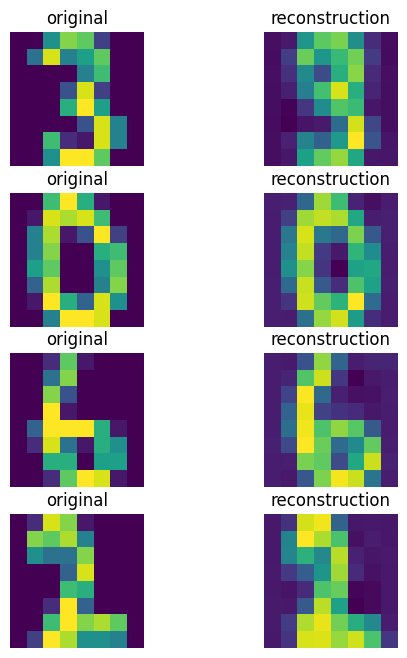

In [20]:
IMG_IDs = [110, 120, 130, 140]
z_sampled = model.entropy_coding.sample(quantizer=model.quantizer, B = 9)
x_sampled = model.decoder(z_sampled)

x_real = torch.from_numpy(test_data.__getitem__(IMG_IDs))
print(x_real.shape)
x_encoder = model.encoder(x_real)
# print(x_encoder)
# print("-----", model.quantizer(model.encoder(x_real)))
x_rec = model.decoder(model.quantizer(model.encoder(x_real))[-1])

fig, axs = plt.subplots(4, 2, figsize=(6, 8))
i = 0
for i in range(len(IMG_IDs)):
    axs[i,0].imshow(x_real[i].reshape(8,8).detach().numpy())
    axs[i,0].set_title('original')
    axs[i,0].axis('off')
    
    axs[i,1].imshow(x_rec[i].reshape(8,8).detach().numpy())
    axs[i,1].set_title('reconstruction')
    axs[i,1].axis('off')
    

In [15]:
# IMG_IDs = [110,]
# x_real = torch.from_numpy(test_data.__getitem__(IMG_IDs))
# print(x_real)
# # x_rec = model.decoder(model.quantizer(model.encoder(x_real))[-1])


# x_encoder = model.encoder(x_real)
# print(x_encoder)
# k, p, e = model.quantizer(x_encoder)
# print("-----", e)
# x_rec = model.decoder(e)
# print(x_rec)

# # fig, axs = plt.subplots(4, 2, figsize=(6, 8))
# # i = 0
# # for i in range(len(IMG_IDs)):
# #     axs[i,0].imshow(x_real[i].reshape(8,8).detach().numpy())
# #     # print image data byte size
# #     print('x_real:', x_real[i].reshape(8,8).detach().numpy().nbytes)
# #     axs[i,0].set_title('original')
# #     axs[i,0].axis('off')
    
# #     axs[i,1].imshow(x_rec[i].reshape(8,8).detach().numpy())
# #     # print image data byte size
# #     print('x_rec:', x_rec[i].reshape(8,8).detach().numpy().nbytes)

# #     axs[i,1].set_title('reconstruction')
# #     axs[i,1].axis('off')


# # plt.savefig(result_dir + name + 'recon_sample.pdf', bbox_inches='tight')

In [16]:
codebook_dim = 2
X = nn.Parameter(torch.FloatTensor(1,codebook_dim, ).uniform_(-1/codebook_dim, 1/codebook_dim))

In [17]:
X

Parameter containing:
tensor([[ 0.0031, -0.2566]], requires_grad=True)

In [18]:
# matrix 8x8 with value random from 0 to 15
X = torch.randint(0, 16, (8, 8))
X

tensor([[ 3,  6, 14, 11,  8,  2, 14, 11],
        [12,  7, 12,  1,  4,  9,  8,  4],
        [12,  7, 13, 13,  3,  5,  4,  9],
        [13,  7, 11,  3,  2,  9,  2, 14],
        [10,  9, 13, 15,  8,  2, 10,  9],
        [12, 11,  0, 13,  8, 10, 10,  8],
        [ 1,  8,  4,  0,  2, 13,  8,  6],
        [14,  8, 12,  4,  4, 10,  5,  2]])

In [19]:
inputs_shape = X.shape

inputs_repeat = X.unsqueeze(2).repeat(1, 1, codebook_dim)
inputs_repeat.shape

torch.Size([8, 8, 2])